# Segmentation to coordinates

This notebook explains how we can go from image segmentation to object coordinates. 


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import os
import pickle

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet

Get project and datasets to get some predictions from the model.

In [5]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [0.5110162496566772, 0.4608974754810333, 0.4772901237010956], 'stds': [0.2727729380130768, 0.2578601539134979, 0.256255567073822]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [6]:
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")
DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 

In [7]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /home/kevin/Documents/trackingProjects/faceTrack/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.5110162496566772, 0.4608974754810333, 0.4772901237010956], std=[0.2727729380130768, 0.2578601539134979, 0.256255567073822], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [8]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform)
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

In [9]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [10]:
imageIndex=3
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

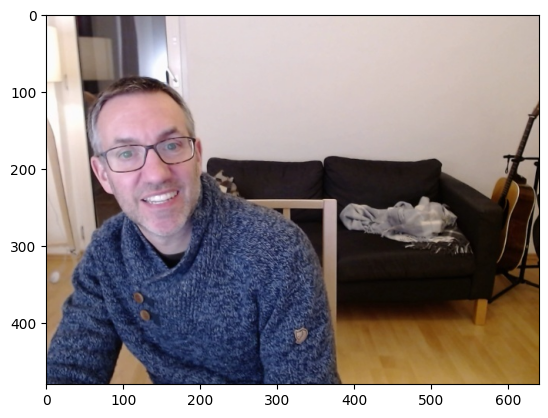

In [11]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [12]:
img = image.permute(1,2,0).numpy() #
msk = mask.numpy() 

### Image and masks for an item of the validation set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


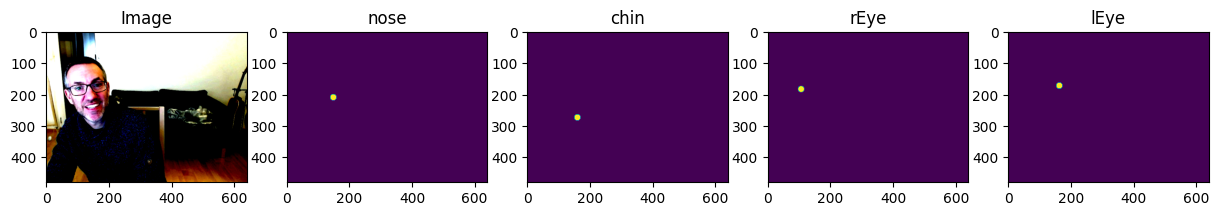

In [13]:
fig, ax = plt.subplots(1,msk.shape[0]+1,figsize=((msk.shape[0]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Image")
for i in range(msk.shape[0]):
    ax[i+1].imshow(msk[i])
    ax[i+1].set_title(project.object_list[i])

### Image and mask predictions of an item of the validation set
Let's get the model output for this image. 

If you use [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), you should apply a sigmoid function to the output as it is usually applied when calculating the loss. 

The sigmoid function limits the range from 0 to 1. 

In [14]:
%%time

image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

CPU times: user 696 ms, sys: 274 ms, total: 970 ms
Wall time: 971 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


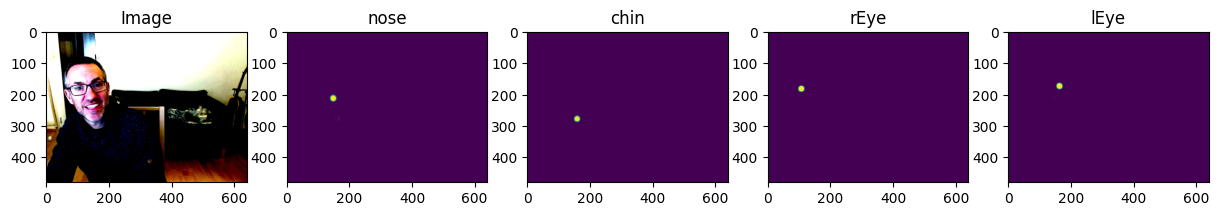

In [15]:
fig, ax = plt.subplots(1,output.shape[1]+1,figsize=((output.shape[1]+1)*3,3))
ax[0].imshow(img)
ax[0].set_title("Image")
for i in range(output.shape[1]):
    ax[i+1].imshow(output[0,i])
    ax[i+1].set_title(project.object_list[i])

## Extracting coordinate out of the mask

A detected object appears as a bright blob in a dark background. 

We can use the cv2.SimpleBlobDetector to detect the objects.

In [16]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 30 # 100 # between 400 and 500 is the decision point
detector = cv2.SimpleBlobDetector_create(params)

In [17]:
blobs = imageOri.astype(np.uint8)
nObjects = output.shape[1]
pred = np.empty((output.shape[0],nObjects,3)) # x, y, probability
pred[:,:,:] = np.nan
pred[:,:,2] = output.reshape(nObjects,-1).max(axis=1) # maximal value in each object mask

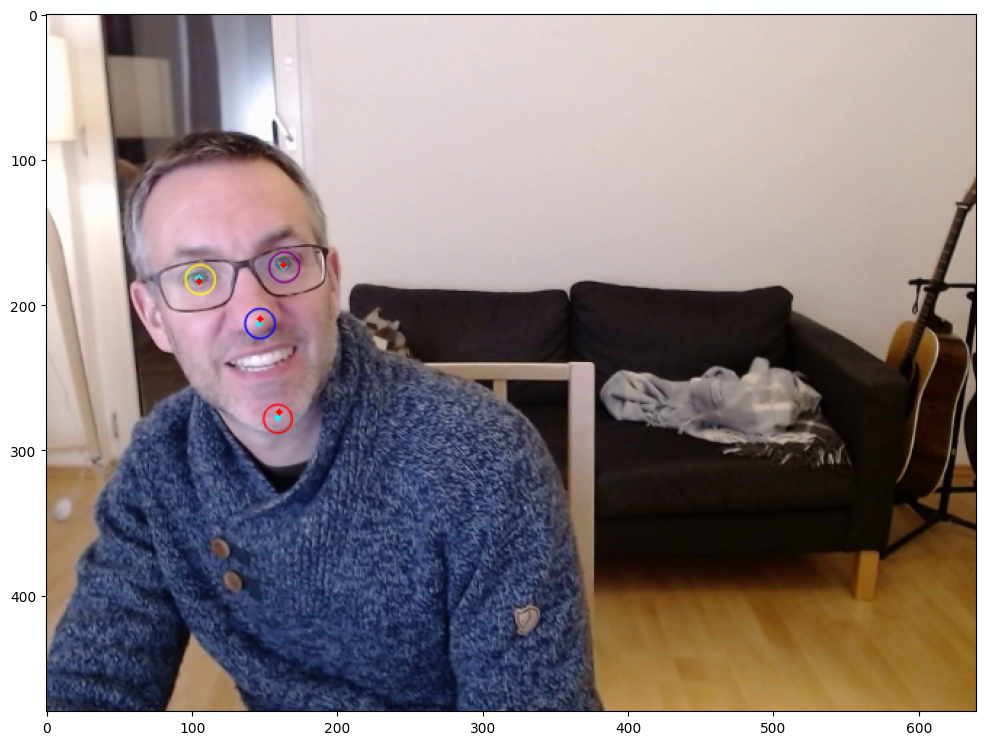

[[[146.79415894 213.14683533   0.99678779]
  [159.0743866  278.54959106   0.9936381 ]
  [105.73188019 182.8891449    0.99976009]
  [163.54457092 174.3346405    0.99934739]]]
[[147. 210.]
 [160. 274.]
 [105. 184.]
 [163. 173.]]


array([3.15356039, 4.64279431, 1.33028105, 1.44146549])

In [18]:
for item in range(1):
    for objectIndex in range(len(project.object_list)):

        out = output[item]
        outputT = np.expand_dims((out[objectIndex]*255).astype(np.uint8),2) # get output in unsigned int 8 format, values ranging from 0 to 255
        outputT= 255-outputT # reverse values because the SimpleBlobDetector is looking for dark blob
       
        
        keypoints = detector.detect(outputT)
        if keypoints:
            blank = np.zeros((1, 1))
            blobs = cv2.drawKeypoints(blobs, keypoints, blank, project.object_colors[objectIndex],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            # find the largest blob
            largest_size=0
            pt = None
            for k in keypoints:
                if k.size>largest_size:
                    pt = k.pt
            pred[item,objectIndex,0] = pt[0]
            pred[item,objectIndex,1] = pt[1]
            cv2.circle(blobs,(int(pt[0]),int(pt[1])), 2, (0,255,255), -1)
            cv2.circle(blobs,(int(coord[objectIndex,0]),int(coord[objectIndex,1])), 2, (255,0,0), -1)
    plt.figure(figsize=(12,12))
    plt.imshow(blobs)
    plt.show()

print(pred)
print(coord)
# distance between predicted coordinates and labeled coordinates
np.sqrt(np.sum((coord-pred[0,:,0:2])**2,axis=1))

## CoordinatesFromSegmentationMask object
We have a class that will extract the predicted coordinates given an output.

In [19]:
image,mask,coord = valDataset[imageIndex]
image = image.unsqueeze(0).to(DEVICE)
output = torch.sigmoid(model(image))
output = output.detach().cpu().numpy()

In [20]:
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask
cDetector = CoordinatesFromSegmentationMask()

In [21]:
pred = cDetector.detect(output)

In [22]:
pred , coord

(array([[[146.79415894, 213.14683533,   0.99678779],
         [159.0743866 , 278.54959106,   0.9936381 ],
         [105.73188019, 182.8891449 ,   0.99976009],
         [163.54457092, 174.3346405 ,   0.99934739]]]),
 array([[147., 210.],
        [160., 274.],
        [105., 184.],
        [163., 173.]]))